<a href="https://colab.research.google.com/github/devashree1923/fake-news-datasets/blob/master/FAKE_NEWS_DETECTION_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM,Dropout, GlobalMaxPool1D#,Bidirectional,GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
## This is the test Data
test_data = pd.read_csv('/content/sample_data/test.csv')
## Import dataset
df = pd.read_csv('/content/sample_data/train.csv')

In [3]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(df.shape[0],df.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test_data.shape[0],test_data.shape[1]))

There are 20800 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


In [6]:
## Check the Null Values 
# Checking the null values in training data.
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# Checking the null values in testing data.
test_data.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [8]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(df,test_data)

In [9]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+train["author"]
test["merged"]  = test["title"]+" "+test["author"]

In [10]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']

In [11]:
# Now count the Unique values to check the data is balanced or not
count = np.unique(train['label'], return_counts=True)
count

(array([0, 1]), array([10387, 10413]))

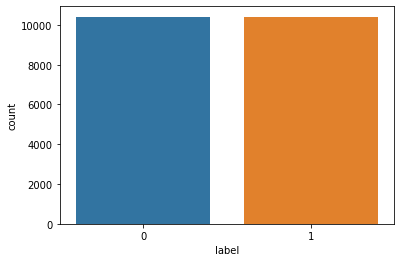

In [13]:
import seaborn as sns
sns.countplot(x='label', data = train)

**One Hot Representation**

In this step we change the dataset into Numerical representation

In [14]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [15]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [16]:
print(len(messages))

20800


**Data Preprocessing**

In [17]:
# ps = PorterStemmer()
# def perform_preprocess(data):
#     '''Input: Data to be processed
#        Output: Preprocessed data
#     '''
#     corpus = []
#     for i in range(0,len(data)):
#         review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
#         review = review.lower()
#         review = review.split()
#         review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
#         review = ' '.join(review)
#         corpus.append(review)
#     return corpus


ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['merged'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [18]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

**Word Embedding**

In [19]:
# pad_sequences
sent_length = 1000
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ...  99 221 190]
 [  0   0   0 ...  42 424 305]
 [  0   0   0 ... 214 364 386]
 ...
 [  0   0   0 ... 274 168 411]
 [  0   0   0 ... 433 365 284]
 [  0   0   0 ... 154 475 303]]


**Creating a Model**

1) LSTM

In [20]:
embedding_vector_feature = 100
model=Sequential()
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(200))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         50000     
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 291,001
Trainable params: 291,001
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20800, 1000), (20800,))

In [22]:
# Training the model
# train model 1
history =  model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

Epoch 1/10
65/65 [==============================] - 16s 199ms/step - loss: 0.4720 - accuracy: 0.8094 - val_loss: 0.2059 - val_accuracy: 0.9168
Epoch 2/10
65/65 [==============================] - 13s 195ms/step - loss: 0.1347 - accuracy: 0.9475 - val_loss: 0.1158 - val_accuracy: 0.9570
Epoch 3/10
65/65 [==============================] - 13s 195ms/step - loss: 0.0817 - accuracy: 0.9710 - val_loss: 0.0950 - val_accuracy: 0.9690
Epoch 4/10
65/65 [==============================] - 13s 198ms/step - loss: 0.0595 - accuracy: 0.9808 - val_loss: 0.0740 - val_accuracy: 0.9774
Epoch 5/10
65/65 [==============================] - 13s 201ms/step - loss: 0.0454 - accuracy: 0.9865 - val_loss: 0.0685 - val_accuracy: 0.9793
Epoch 6/10
65/65 [==============================] - 13s 202ms/step - loss: 0.0396 - accuracy: 0.9880 - val_loss: 0.0664 - val_accuracy: 0.9800
Epoch 7/10
65/65 [==============================] - 13s 201ms/step - loss: 0.0317 - accuracy: 0.9902 - val_loss: 0.0673 - val_accuracy: 0.9810

In [48]:
predict_x = model.predict(x_test)
predictions = np.argmax(predict_x,axis=1)
cr = classification_report(y_test,predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1039
           1       0.00      0.00      0.00      1041

    accuracy                           0.50      2080
   macro avg       0.25      0.50      0.33      2080
weighted avg       0.25      0.50      0.33      2080



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


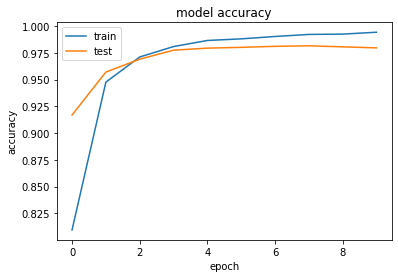

In [28]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

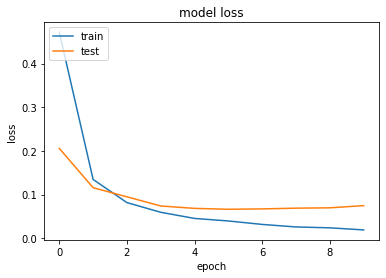

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2) LSTM-Modified

Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.

In [31]:
# # Creating the LSTM Model for prediction
# embedding_feature_vector = 40
# model = Sequential()
# model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
# model.add(Dropout(0.3))
# model.add(LSTM(100))
# model.add(Dropout(0.3))
# model.add(Dense(1,activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# print(model.summary())


model = Sequential()
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(100, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# train model 2
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

Epoch 1/10
65/65 [==============================] - 10s 110ms/step - loss: 0.4073 - accuracy: 0.8358 - val_loss: 0.1792 - val_accuracy: 0.9269
Epoch 2/10
65/65 [==============================] - 7s 105ms/step - loss: 0.1294 - accuracy: 0.9518 - val_loss: 0.1270 - val_accuracy: 0.9483
Epoch 3/10
65/65 [==============================] - 7s 114ms/step - loss: 0.0840 - accuracy: 0.9709 - val_loss: 0.0921 - val_accuracy: 0.9685
Epoch 4/10
65/65 [==============================] - 7s 107ms/step - loss: 0.0616 - accuracy: 0.9812 - val_loss: 0.0747 - val_accuracy: 0.9755
Epoch 5/10
65/65 [==============================] - 7s 105ms/step - loss: 0.0503 - accuracy: 0.9842 - val_loss: 0.0800 - val_accuracy: 0.9743
Epoch 6/10
65/65 [==============================] - 7s 104ms/step - loss: 0.0389 - accuracy: 0.9889 - val_loss: 0.0675 - val_accuracy: 0.9805
Epoch 7/10
65/65 [==============================] - 7s 104ms/step - loss: 0.0306 - accuracy: 0.9916 - val_loss: 0.0695 - val_accuracy: 0.9793
Epoch

In [49]:
predict_x = model.predict(x_test)
predictions_2 = np.argmax(predict_x,axis=1)
cr = classification_report(y_test,predictions_2)
print(cr)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1039
           1       0.00      0.00      0.00      1041

    accuracy                           0.50      2080
   macro avg       0.25      0.50      0.33      2080
weighted avg       0.25      0.50      0.33      2080



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


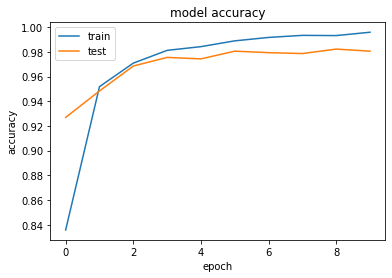

In [34]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

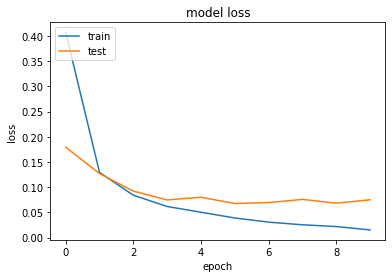

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Splitting into Training Testing data**

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
# x_test_final = x_test_final

3) Logistic Regression

In [42]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(x_train,y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.69      0.74      0.72      1039
           1       0.72      0.67      0.69      1041

    accuracy                           0.71      2080
   macro avg       0.71      0.71      0.71      2080
weighted avg       0.71      0.71      0.71      2080



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


4) Naive Bayes

In [43]:
model_2 = MultinomialNB()
model_2.fit(X_train,Y_train)
pred_2 = model_2.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1039
           1       0.66      0.74      0.70      1041

    accuracy                           0.68      2080
   macro avg       0.68      0.68      0.68      2080
weighted avg       0.68      0.68      0.68      2080



5) Decision Trees

In [44]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1039
           1       0.89      0.88      0.88      1041

    accuracy                           0.88      2080
   macro avg       0.88      0.88      0.88      2080
weighted avg       0.88      0.88      0.88      2080



6) Random Forest

In [45]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1039
           1       0.87      0.87      0.87      1041

    accuracy                           0.87      2080
   macro avg       0.87      0.87      0.87      2080
weighted avg       0.87      0.87      0.87      2080



7) XGBoost

In [46]:
model_5 = XGBClassifier()
model_5.fit(X_train,Y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1039
           1       0.88      0.95      0.91      1041

    accuracy                           0.91      2080
   macro avg       0.91      0.91      0.91      2080
weighted avg       0.91      0.91      0.91      2080



**Evaluating Models**

In [50]:
score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,pred_4)
score_5 = accuracy_score(y_test,pred_5)
score_6 = accuracy_score(y_test,predictions)
score_7 = accuracy_score(y_test,predictions_2)
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4],["XGBOOST",score_5],["LSTM",score_6*2],["LSTM-Modified",score_7*2]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.705769
1,Naive Bayes,0.678846
2,Decision Tree,0.884615
3,Random Forest,0.868750
4,XGBOOST,0.911058
5,LSTM,0.999038
6,LSTM-Modified,0.999038


In [53]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [55]:
from catboost import CatBoostClassifier
model_6 = CatBoostClassifier(iterations=200)
model_6.fit(X_train,Y_train)
pred_6 = model_6.predict(x_test)
cr6    = classification_report(y_test,pred_6)
print(cr6)

Learning rate set to 0.150531
0:	learn: 0.5931830	total: 38.3ms	remaining: 7.62s
1:	learn: 0.5191896	total: 78.3ms	remaining: 7.75s
2:	learn: 0.4670388	total: 126ms	remaining: 8.26s
3:	learn: 0.4218927	total: 159ms	remaining: 7.8s
4:	learn: 0.4029660	total: 183ms	remaining: 7.12s
5:	learn: 0.3883842	total: 211ms	remaining: 6.82s
6:	learn: 0.3716388	total: 254ms	remaining: 7.01s
7:	learn: 0.3634901	total: 281ms	remaining: 6.74s
8:	learn: 0.3555048	total: 294ms	remaining: 6.25s
9:	learn: 0.3426069	total: 308ms	remaining: 5.85s
10:	learn: 0.3341558	total: 335ms	remaining: 5.75s
11:	learn: 0.3283744	total: 366ms	remaining: 5.74s
12:	learn: 0.3221231	total: 401ms	remaining: 5.77s
13:	learn: 0.3184442	total: 435ms	remaining: 5.78s
14:	learn: 0.3150411	total: 449ms	remaining: 5.53s
15:	learn: 0.3095936	total: 462ms	remaining: 5.31s
16:	learn: 0.3034058	total: 475ms	remaining: 5.11s
17:	learn: 0.2994527	total: 487ms	remaining: 4.93s
18:	learn: 0.2904083	total: 502ms	remaining: 4.78s
19:	learn:

In [56]:


score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,pred_4)
score_5 = accuracy_score(y_test,pred_5)
score_6 = accuracy_score(y_test,predictions)
score_7 = accuracy_score(y_test,predictions_2)
score_8 = accuracy_score(y_test,pred_6)
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4],["XGBOOST",score_5],["LSTM",score_6*2],["LSTM-Modified",score_7*2], ["Cat Boost",score_8]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.705769
1,Naive Bayes,0.678846
2,Decision Tree,0.884615
3,Random Forest,0.868750
4,XGBOOST,0.911058
5,LSTM,0.999038
6,LSTM-Modified,0.999038
7,Cat Boost,0.974038
